# IMPORT LIBRARIES, DATASET and MODEL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import os
import joblib

from sklearn.model_selection import train_test_split

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# Import Datasets

df_train = pd.read_csv('Data_for_Modelling/df_train.csv', sep=',')
df_train.drop('Unnamed: 0', axis=1, inplace=True)

print(f"Train set shape:{df_train.shape}")

Train set shape:(377042, 11)


In [3]:
# Split df_train 

X = df_train.drop('Response', axis=1)
y = df_train['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [65]:
# Load model to be explained

xgb_model_with_ADASYN = joblib.load('Models/Models_with_ADASYN/XGBoost_with_ADASYN.joblib')

# GLOBAL EXPLANATION

In [67]:
# Initialize and fit Permutation Importance object

perm = PermutationImportance(xgb_model_with_ADASYN, random_state=42)

perm.fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0388 ± 0.0030,Vehicle_Age
0.0339 ± 0.0015,Age
0.0038 ± 0.0018,Gender
0.0036 ± 0.0014,Region_Code
0.0003 ± 0.0005,Vintage
-0.0000 ± 0.0001,Driving_License
-0.0009 ± 0.0005,Annual_Premium
-0.0127 ± 0.0033,Policy_Sales_Channel
-0.0291 ± 0.0028,Vehicle_Damage
-0.0315 ± 0.0027,Previously_Insured


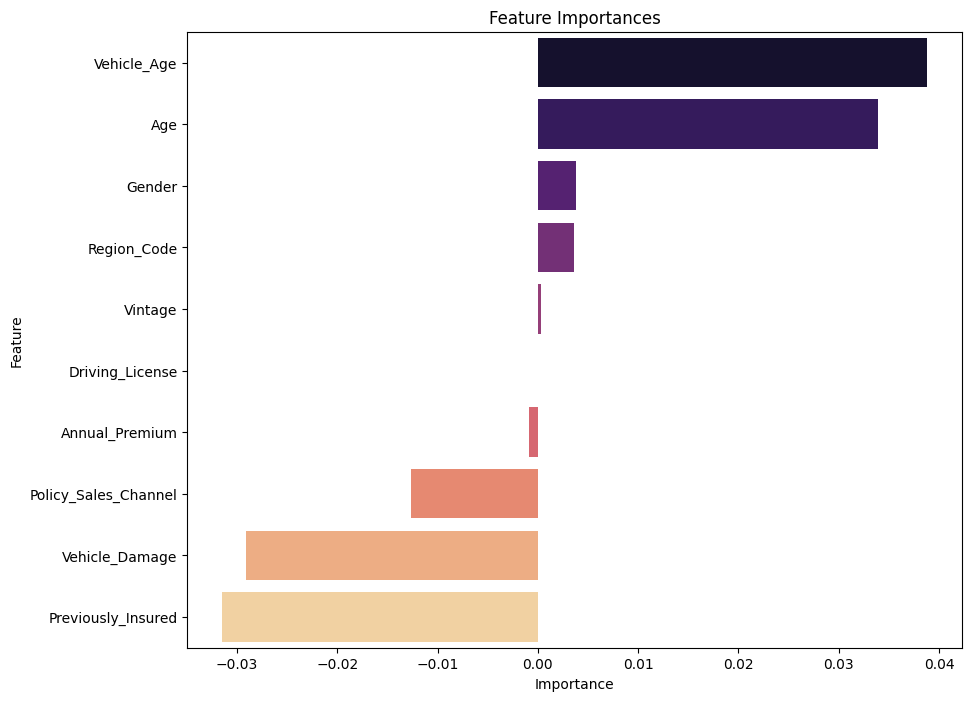

In [68]:
# Plot global feature importance

feature_importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='magma', hue='feature', dodge=False, legend=False)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# LOCAL EXPLANATION

In [123]:
# Supponiamo che tu voglia spiegare la prima predizione

subject = 3

explanation = eli5.show_prediction(xgb_model_with_ADASYN, X_test.iloc[subject], show_feature_values=True)
explanation

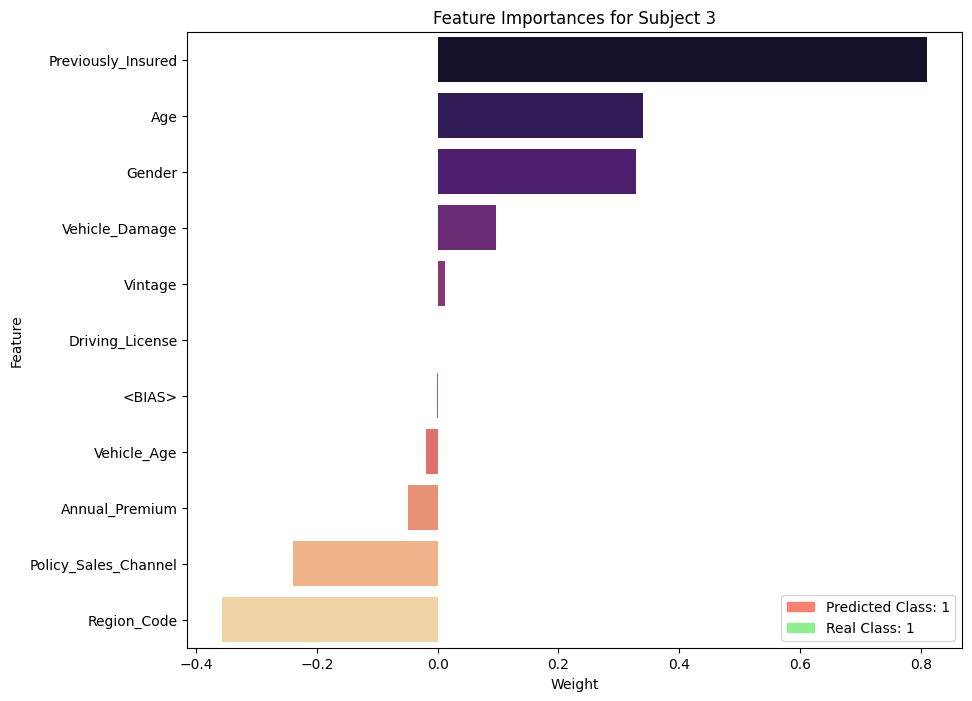

In [129]:
# Plot feature importance for single subject

predicted_class = xgb_model_with_ADASYN.predict(X_test.iloc[subject:subject+1])[0]
real_class = y_test.iloc[subject]

explanation = eli5.explain_prediction(xgb_model_with_ADASYN, X_test.iloc[subject])

feature_weights = explanation.targets[0].feature_weights

feature_importances = []
for weight in feature_weights.pos:
    feature_importances.append({'feature': weight.feature, 'weight': weight.weight})

for weight in feature_weights.neg:
    feature_importances.append({'feature': weight.feature, 'weight': weight.weight})

feature_importances_df = pd.DataFrame(feature_importances)
feature_importances_df = feature_importances_df.sort_values(by='weight', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='weight', y='feature', data=feature_importances_df, hue='feature', palette='magma')

predicted_patch = mpatches.Patch(color='salmon', label=f'Predicted Class: {predicted_class}')
real_patch = mpatches.Patch(color='lightgreen', label=f'Real Class: {real_class}')
plt.legend(handles=[predicted_patch, real_patch],loc='lower right')

plt.title(f'Feature Importances for Subject {subject}')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.show()
